In [319]:
import os
import shared.data_utils as data_utils
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import modules

#torch.set_printoptions(profile="full")

In [320]:
torch.manual_seed(123)
""" 
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn """

' \ntorch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul\ntorch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn '

## Prepare synthetic dataset

C:\Users\charl\AppData\Local\Temp\ipykernel_16416\3682795813.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {'vertices': data_utils.dequantize_verts(torch.tensor(shape['vertices'])),
C:\Users\charl\AppData\Local\Temp\ipykernel_16416\3682795813.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})


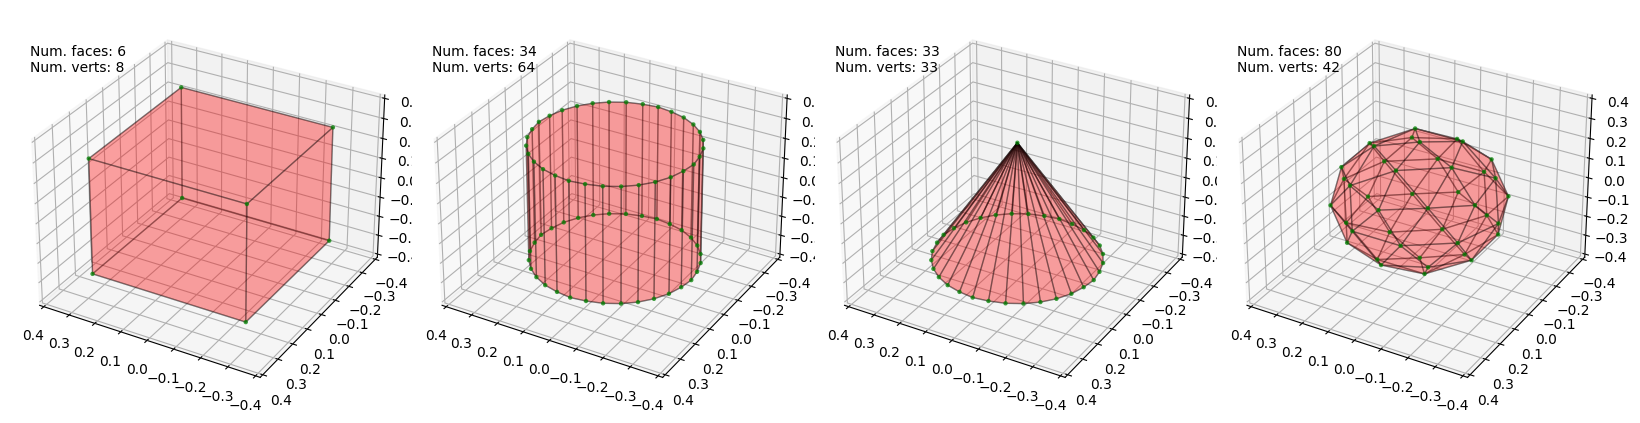

In [321]:
import importlib
importlib.reload(data_utils) 


class MeshDataset(Dataset):
    def __init__(self, mesh_list):
        self.mesh_list = mesh_list 

    def __len__(self):
        return len(self.mesh_list)

    def __getitem__(self, idx):
        return self.mesh_list[idx]
    
    def map(self, func):
        for i in range(len(self.mesh_list)):
           self.mesh_list[i] = func(self.mesh_list[i])
        return self

# Prepare synthetic dataset
ex_list = []
for k, mesh in enumerate(['cube', 'cylinder', 'cone', 'icosphere']):
    mesh_dict = data_utils.load_process_mesh(
        os.path.join('meshes', '{}.obj'.format(mesh)))
    mesh_dict['class_label'] = k
    mesh_dict['vertices'] = torch.tensor(mesh_dict['vertices'])
    mesh_dict['faces'] = torch.tensor(mesh_dict['faces'])
    ex_list.append(mesh_dict)

synthetic_dataset = MeshDataset(ex_list)

# Plot the meshes
mesh_list = []
for shape in synthetic_dataset:
  mesh_list.append(
      {'vertices': data_utils.dequantize_verts(torch.tensor(shape['vertices'])),
        'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})
data_utils.plot_meshes(mesh_list, ax_lims=0.4)

In [322]:
batch_size = 4
shuffle = False

## Create vertex model

In [323]:
import importlib
importlib.reload(data_utils) 
importlib.reload(modules) 
import shared.math_utils as math_utils
importlib.reload(math_utils) 

# Prepare the dataset for vertex model training
def pad_batch(batch):
    items = np.array([list(item.values()) for item in batch])
    packed_dict = {}
    for i, key in enumerate(batch[0].keys()):
        if not isinstance(items[:, i][0], torch.Tensor):
            packed_dict[key] = torch.tensor(items[:, i].astype(np.int64))
            continue # dont pad class labels
        padded_values = torch.nn.utils.rnn.pad_sequence(items[:, i], batch_first=True)
        packed_dict[key] = padded_values
    return packed_dict

vertex_model_dataset = data_utils.make_vertex_model_dataset(
    synthetic_dataset, apply_random_shift=False)

vertex_model_dataloader = DataLoader(vertex_model_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=pad_batch)
vertex_model_dataloader = iter(vertex_model_dataloader)
vertex_model_batch = next(vertex_model_dataloader)

max_vert_len = max([shape['vertices'].shape[0] for shape in synthetic_dataset])
#print("XX", max_vert_len)
#max_num_input_verts=max_vert_len
max_num_input_verts=250

decoder_config={
        'embd_size': 128,
        'fc_size': 512, 
        'num_layers': 3,
        'dropout_rate': 0.,
        'take_context_embedding': False
}
""" decoder_config={
        'embd_size': 128,
        'fc_size': 512, 
        'num_layers': 3,
        'n_head':4,
        'dropout_rate': 0.,
        'take_context_embedding': True,
        'batch_first': True,
        'norm_first': True
} """
# Create vertex model
vertex_model = modules.VertexModel(
    decoder_config=decoder_config,
    class_conditional=True,
    num_classes=4,
    max_num_input_verts=max_num_input_verts,
    quantization_bits=8
)
vertex_model_pred_dist = vertex_model(vertex_model_batch)

vertex_model_loss = -torch.sum(
    vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) * 
    vertex_model_batch['vertices_flat_mask'])

vertex_samples = vertex_model.sample(
    4, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
    recenter_verts=False, only_return_complete=False)

#print(vertex_model_batch)
#print(vertex_model_pred_dist)
#print(vertex_samples)

C:\Users\charl\AppData\Local\Temp\ipykernel_16416\1768744462.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  items = np.array([list(item.values()) for item in batch])
C:\Users\charl\AppData\Local\Temp\ipykernel_16416\1768744462.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.array([list(item.values()) for item in batch])


## Create face model

In [ ]:
import importlib
importlib.reload(data_utils) 
importlib.reload(modules) 
import shared.math_utils as math_utils
importlib.reload(math_utils) 

face_model_dataset = data_utils.make_face_model_dataset(
    synthetic_dataset, apply_random_shift=False)

face_model_dataloader = DataLoader(face_model_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=pad_batch)
face_model_dataloader = iter(face_model_dataloader)
face_model_batch = next(face_model_dataloader)
print(face_model_batch)
""" encoder_config={
        'embd_size': 128,
        'fc_size': 512, 
        'num_layers': 3,
        'dropout_rate': 0.,
        'n_head':4,
        'batch_first': True,
        'norm_first': True
}
decoder_config={
    'embd_size': 128,
    'fc_size': 512, 
    'num_layers': 3,
    'dropout_rate': 0.,
    'take_context_embedding': True,
    'n_head':4,
    'batch_first': True,
    'norm_first': True
} """
encoder_config={
        'embd_size': 128,
        'fc_size': 512, 
        'num_layers': 3,
        'dropout_rate': 0.
}
decoder_config={
    'embd_size': 128,
    'fc_size': 512, 
    'num_layers': 3,
    'dropout_rate': 0.,
    'take_context_embedding': True
}

# Create face model
face_model = modules.FaceModel(
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    class_conditional=False,
    max_seq_length=500,
    quantization_bits=8,
    max_num_input_verts=max_num_input_verts,
    decoder_cross_attention=True,
    use_discrete_vertex_embeddings=True,
)

face_model_pred_dist = face_model(face_model_batch)
face_model_loss = -torch.sum(face_model_pred_dist.log_prob(face_model_batch['faces']) * 
    face_model_batch['faces_mask'])

face_samples = face_model.sample(
    context=vertex_samples, max_sample_length=500, top_p=0.95,
    only_return_complete=False)
#print(face_model_batch)
#print(face_model_pred_dist)
#print(face_samples)


C:\Users\charl\AppData\Local\Temp\ipykernel_16416\1768744462.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  items = np.array([list(item.values()) for item in batch])
C:\Users\charl\AppData\Local\Temp\ipykernel_16416\1768744462.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.array([list(item.values()) for item in batch])


{'vertices': tensor([[[-0.2922, -0.2922,  0.2882],
         [-0.2922, -0.2922, -0.2922],
         [ 0.2882, -0.2922, -0.2922],
         [ 0.2882,  0.2882, -0.2922],
         [ 0.2882, -0.2922,  0.2882],
         [-0.2922,  0.2882,  0.2882],
         [-0.2922,  0.2882, -0.2922],
         [ 0.2882,  0.2882,  0.2882],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],

C:\Users\charl\AppData\Local\Temp\ipykernel_16416\1768744462.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  items = np.array([list(item.values()) for item in batch])
C:\Users\charl\AppData\Local\Temp\ipykernel_16416\1768744462.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.array([list(item.values()) for item in batch])


Step 0
Loss (vertices) 2924.3798828125
Loss (faces) 3504.307861328125
Time (ms): 327.9998302459717


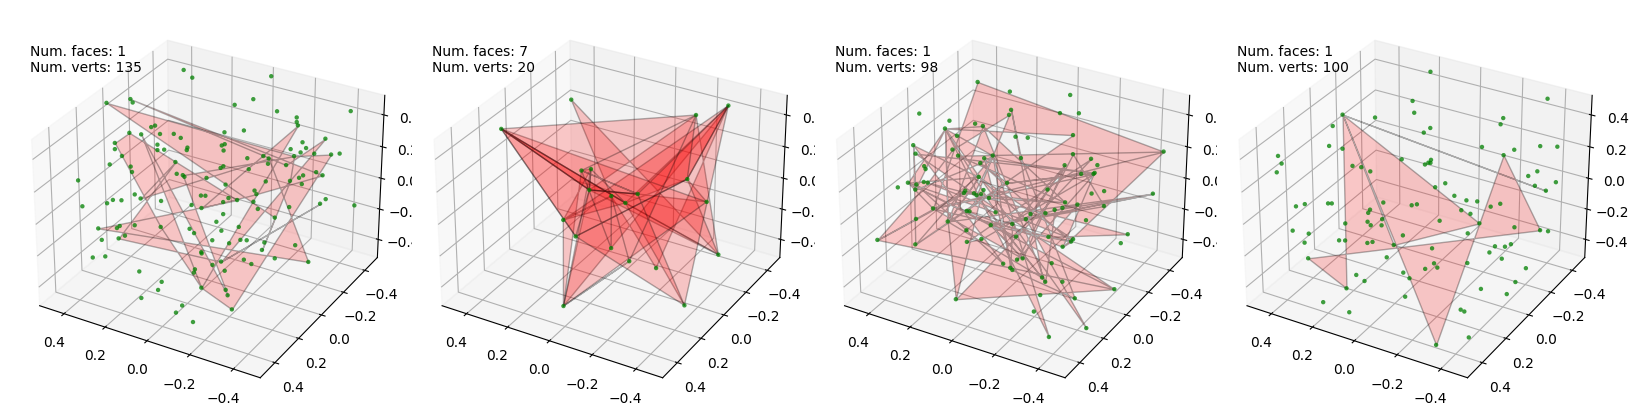

Step 5
Loss (vertices) 2667.2509765625
Loss (faces) 2992.644287109375
Time (ms): 267.0004367828369
Step 10
Loss (vertices) 2267.60107421875
Loss (faces) 2550.12109375
Time (ms): 274.9953269958496
Error plotting meshes... skipping.
Step 15
Loss (vertices) 1798.013427734375
Loss (faces) 2276.14990234375
Time (ms): 382.0009231567383
Step 20
Loss (vertices) 1475.683837890625
Loss (faces) 2021.751953125
Time (ms): 267.99845695495605


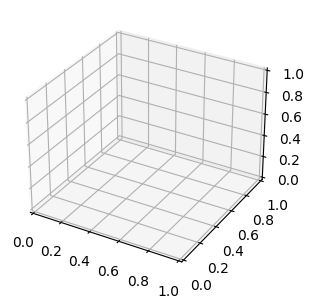

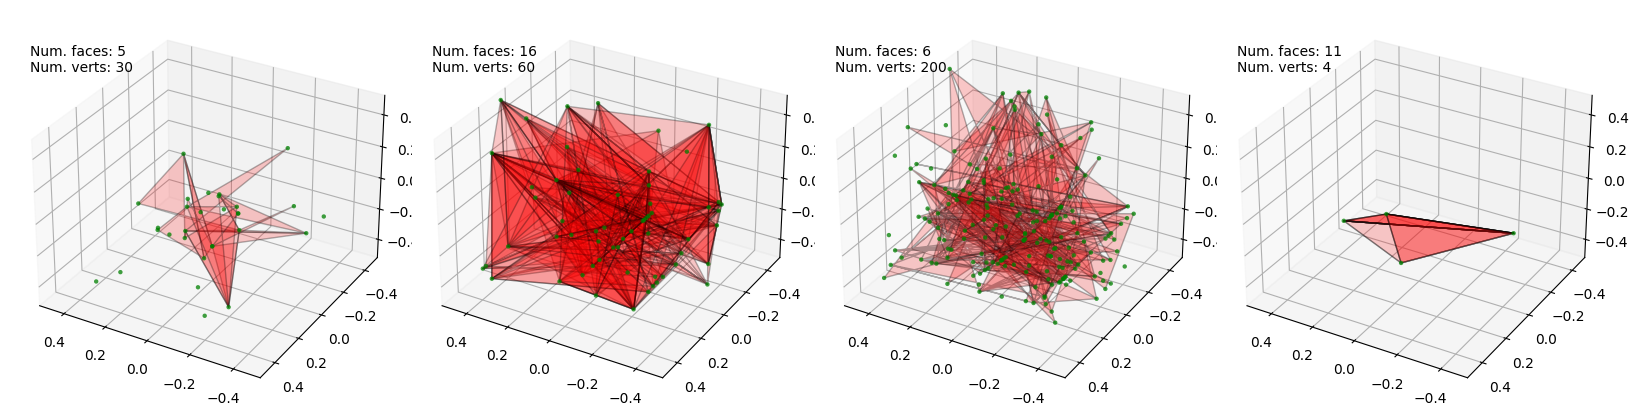

Step 25
Loss (vertices) 1187.0145263671875
Loss (faces) 1822.965576171875
Time (ms): 271.0001468658447
Step 30
Loss (vertices) 969.1128540039062
Loss (faces) 1642.2933349609375
Time (ms): 263.99898529052734


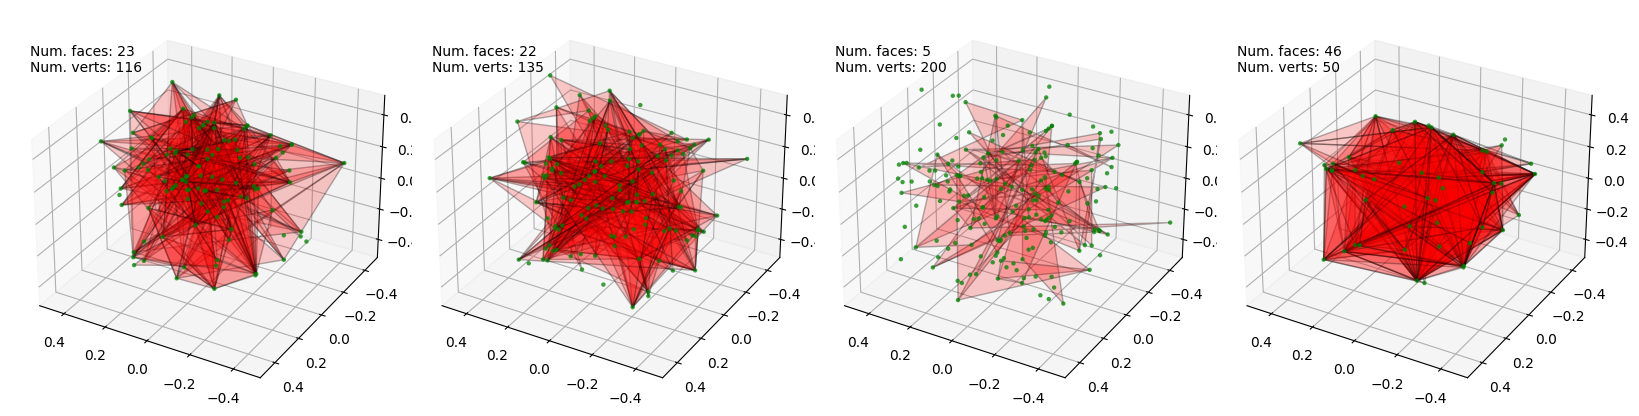

Step 35
Loss (vertices) 753.6218872070312
Loss (faces) 1474.48876953125
Time (ms): 263.99898529052734
Step 40
Loss (vertices) 565.171630859375
Loss (faces) 1314.895751953125
Time (ms): 376.9996166229248


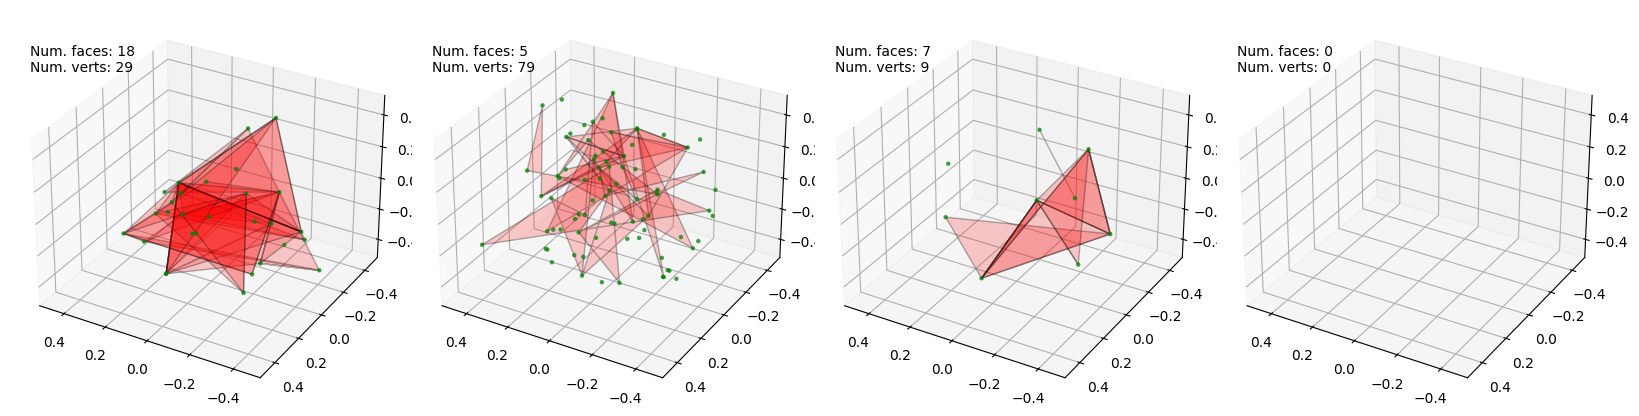

Step 45
Loss (vertices) 393.66650390625
Loss (faces) 1166.573486328125
Time (ms): 289.5185947418213
Step 50
Loss (vertices) 256.8170471191406
Loss (faces) 1024.173095703125
Time (ms): 313.0004405975342


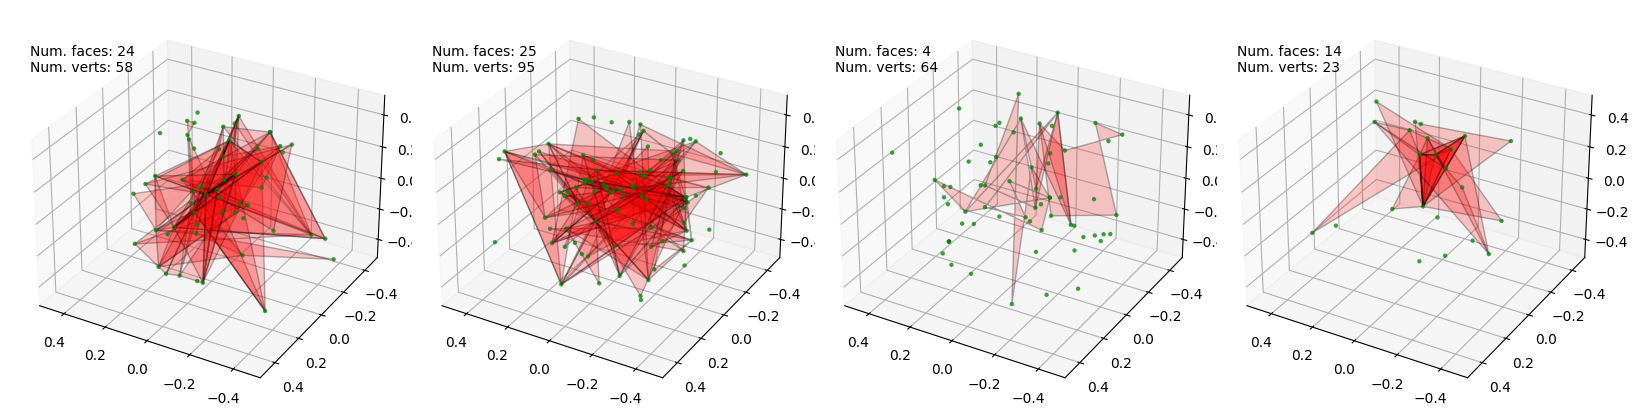

Step 55
Loss (vertices) 161.39244079589844
Loss (faces) 888.1311645507812
Time (ms): 472.99957275390625
Step 60
Loss (vertices) 98.35930633544922
Loss (faces) 760.0735473632812
Time (ms): 324.0013122558594


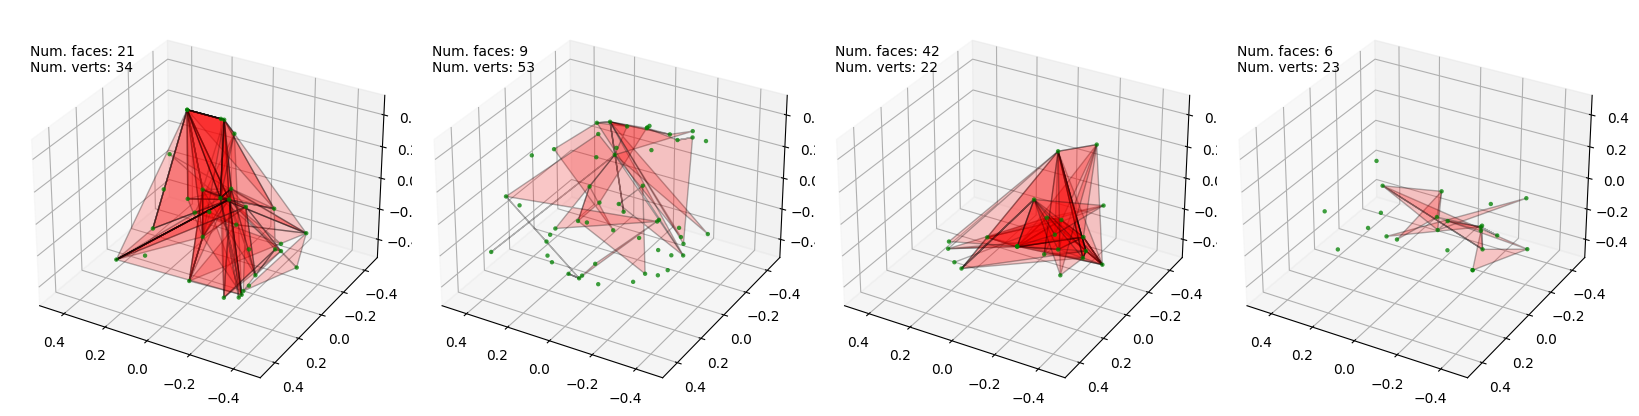

Step 65
Loss (vertices) 60.8870735168457
Loss (faces) 627.0639038085938
Time (ms): 259.9968910217285
Step 70
Loss (vertices) 39.50431442260742
Loss (faces) 512.410888671875
Time (ms): 270.99037170410156


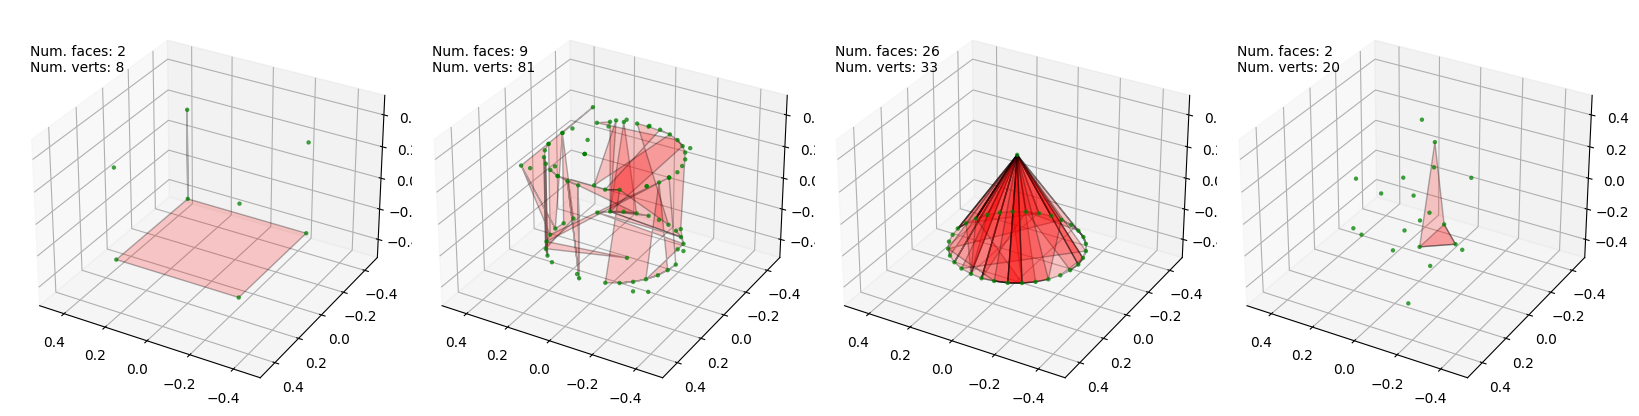

Step 75
Loss (vertices) 27.205101013183594
Loss (faces) 412.7248229980469
Time (ms): 270.0021266937256
Step 80
Loss (vertices) 19.963294982910156
Loss (faces) 359.6647033691406
Time (ms): 262.9988193511963


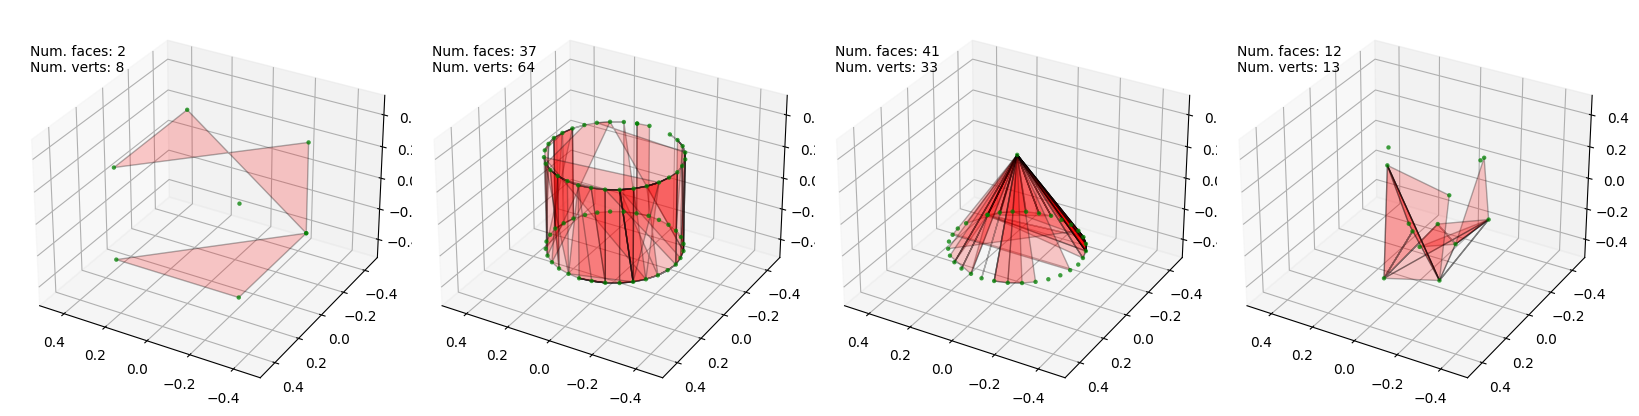

Step 85
Loss (vertices) 15.534358978271484
Loss (faces) 316.8976745605469
Time (ms): 289.9975776672363
Step 90
Loss (vertices) 12.613234519958496
Loss (faces) 239.61672973632812
Time (ms): 298.9978790283203


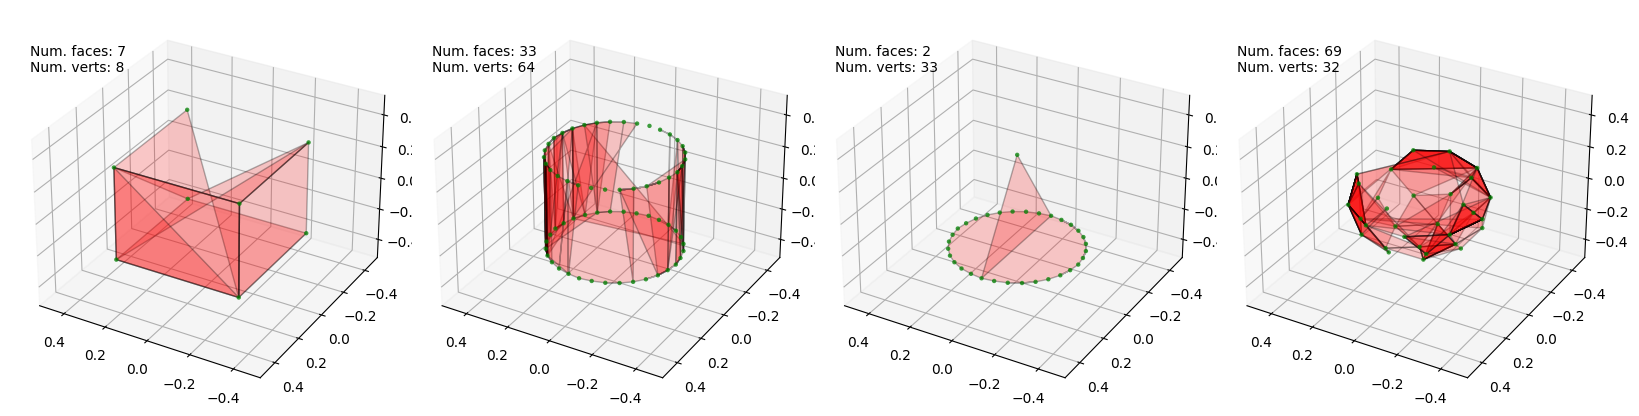

Step 95
Loss (vertices) 10.596606254577637
Loss (faces) 186.75390625
Time (ms): 259.0005397796631
Step 100
Loss (vertices) 9.14483642578125
Loss (faces) 144.24554443359375
Time (ms): 399.0011215209961


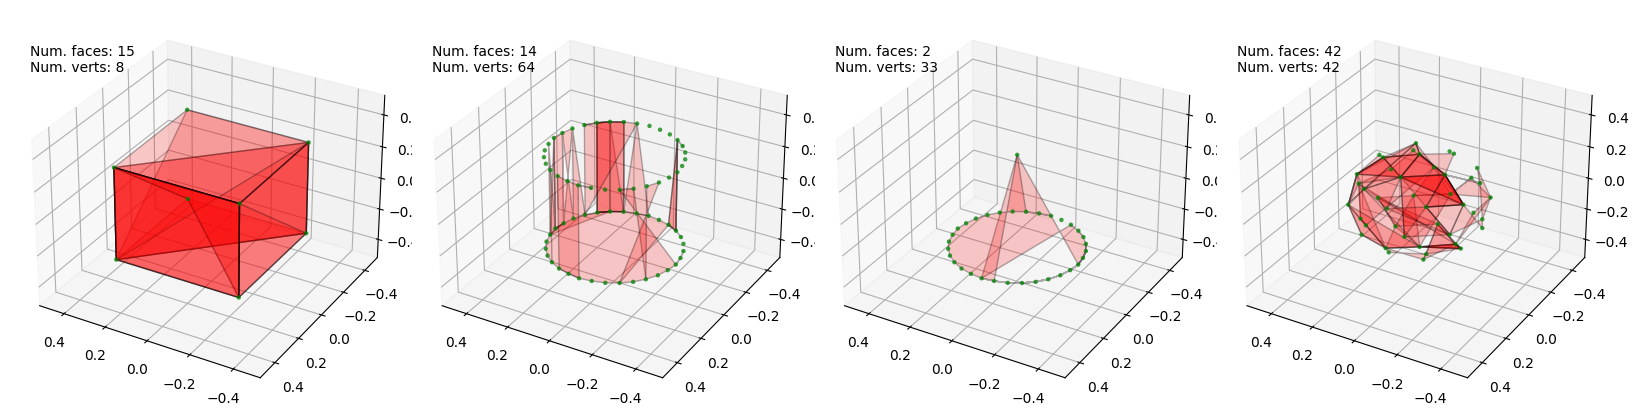

Step 105
Loss (vertices) 8.056398391723633
Loss (faces) 111.24241638183594
Time (ms): 269.0002918243408
Step 110
Loss (vertices) 7.212802886962891
Loss (faces) 87.90316772460938
Time (ms): 273.9999294281006


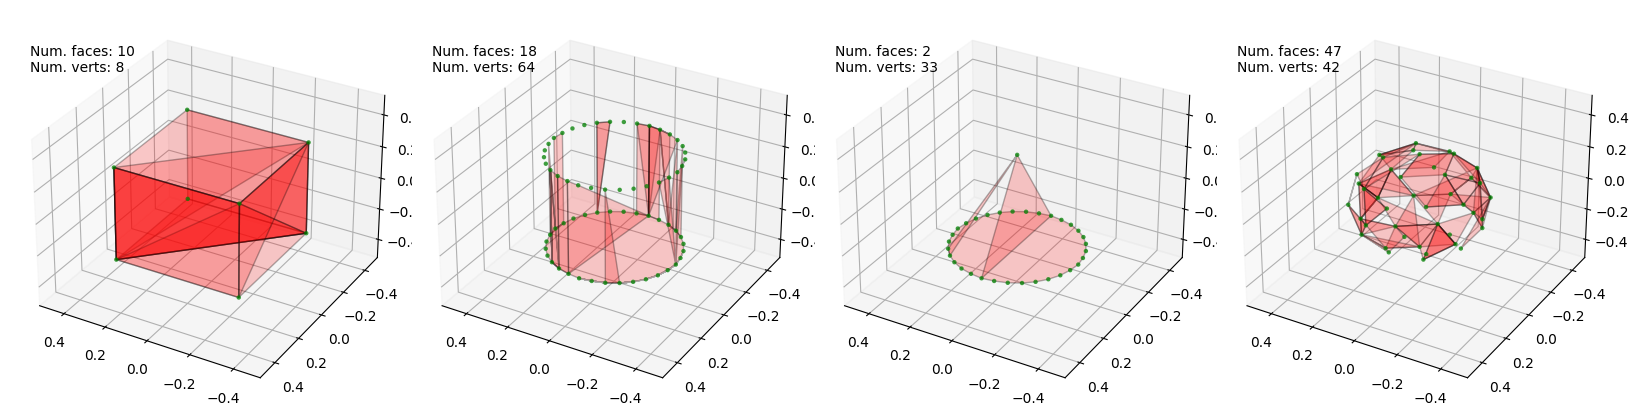

Step 115
Loss (vertices) 6.5338335037231445
Loss (faces) 71.55941772460938
Time (ms): 322.62301445007324
Step 120
Loss (vertices) 5.981825828552246
Loss (faces) 56.79318618774414
Time (ms): 272.0019817352295


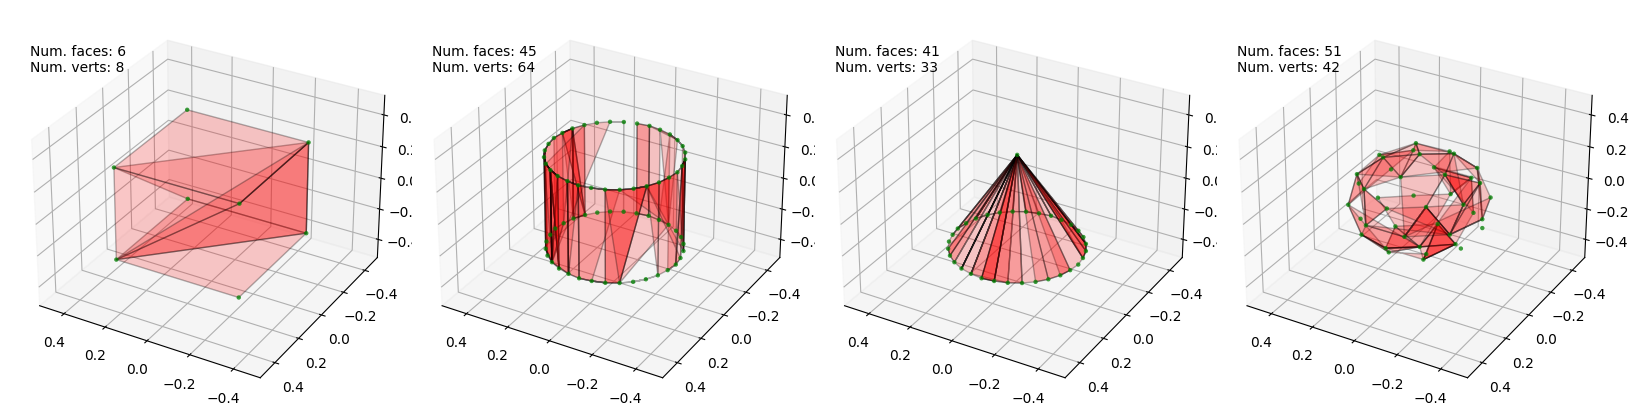

Step 125
Loss (vertices) 5.517314910888672
Loss (faces) 44.925743103027344
Time (ms): 315.9961700439453
Step 130
Loss (vertices) 5.120682716369629
Loss (faces) 36.034061431884766
Time (ms): 295.0024604797363


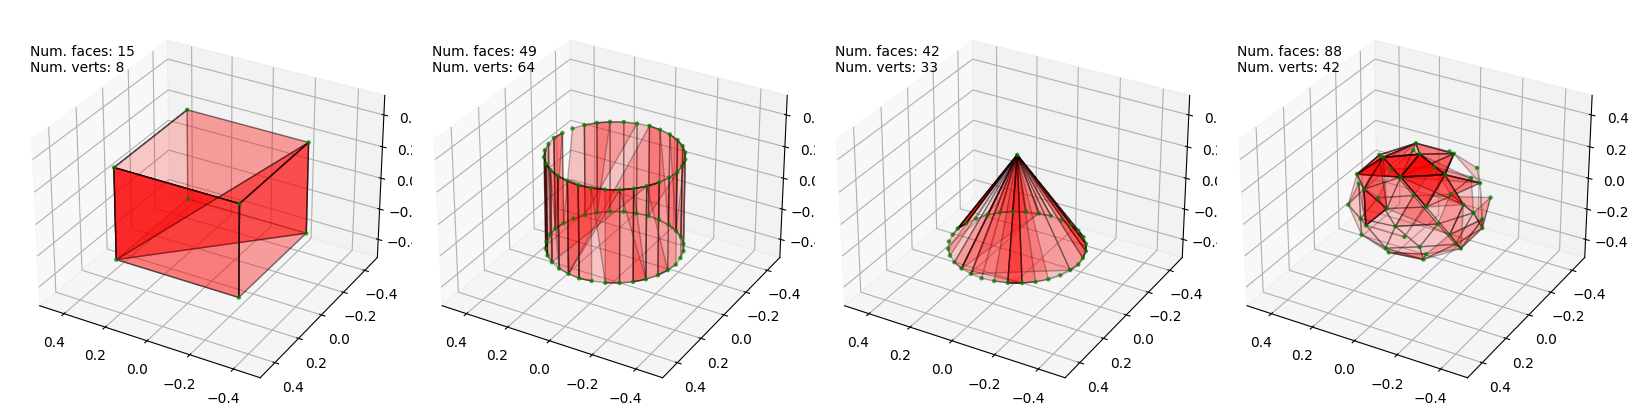

Step 135
Loss (vertices) 4.774641990661621
Loss (faces) 29.402158737182617
Time (ms): 266.00146293640137
Step 140
Loss (vertices) 4.469778060913086
Loss (faces) 24.54724884033203
Time (ms): 301.9983768463135


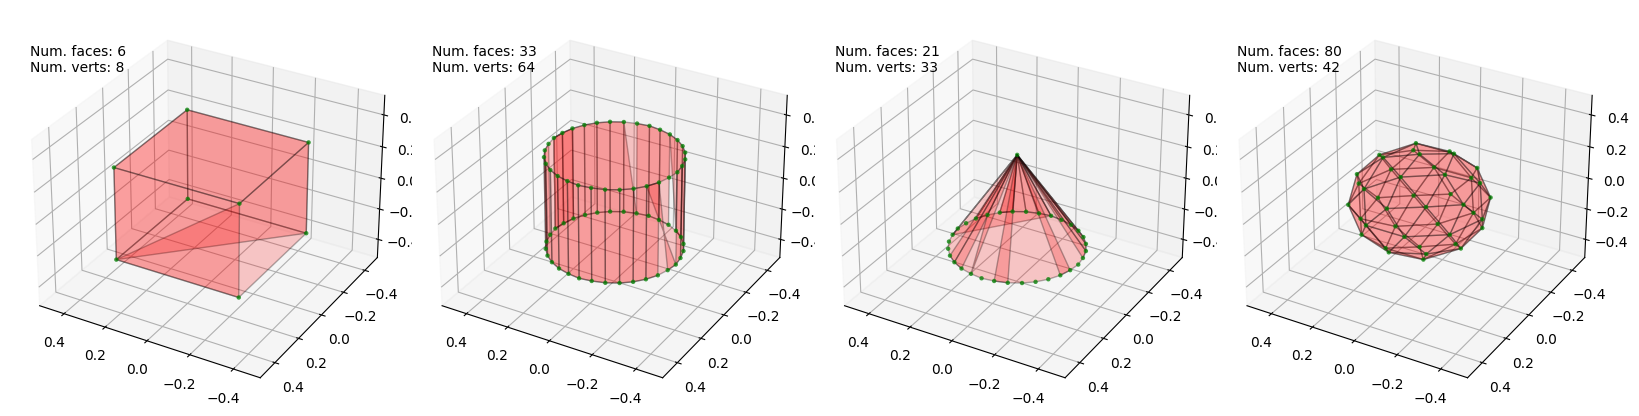

Step 145
Loss (vertices) 4.199728012084961
Loss (faces) 20.839265823364258
Time (ms): 276.9908905029297
Step 150
Loss (vertices) 3.959296226501465
Loss (faces) 18.106962203979492
Time (ms): 296.9973087310791


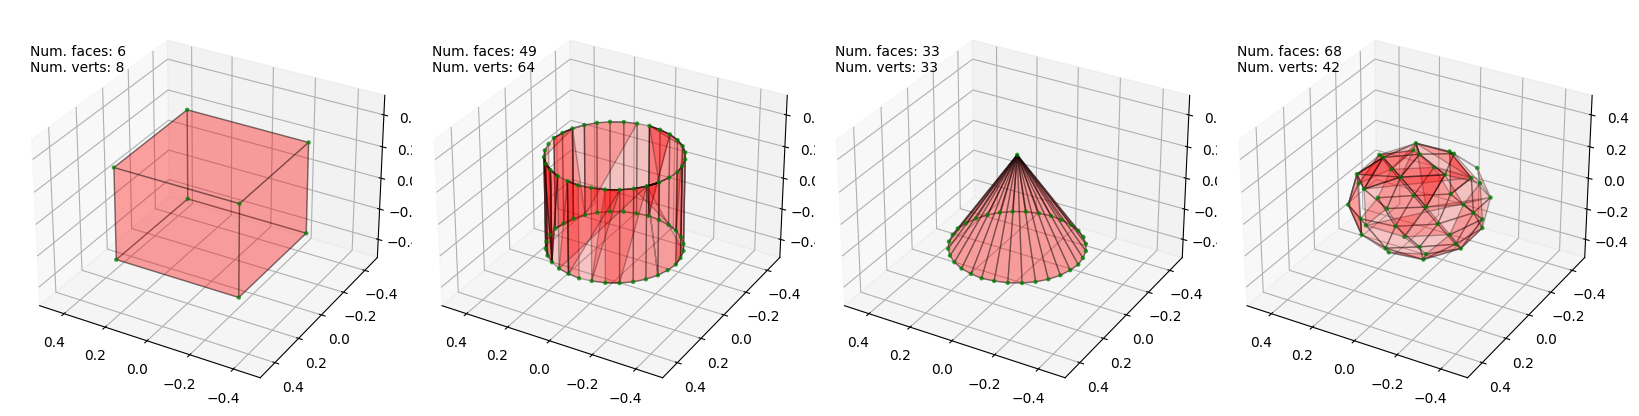

Step 155
Loss (vertices) 3.742997169494629
Loss (faces) 15.984711647033691
Time (ms): 268.99147033691406
Step 160
Loss (vertices) 3.5464134216308594
Loss (faces) 14.243880271911621
Time (ms): 364.99905586242676


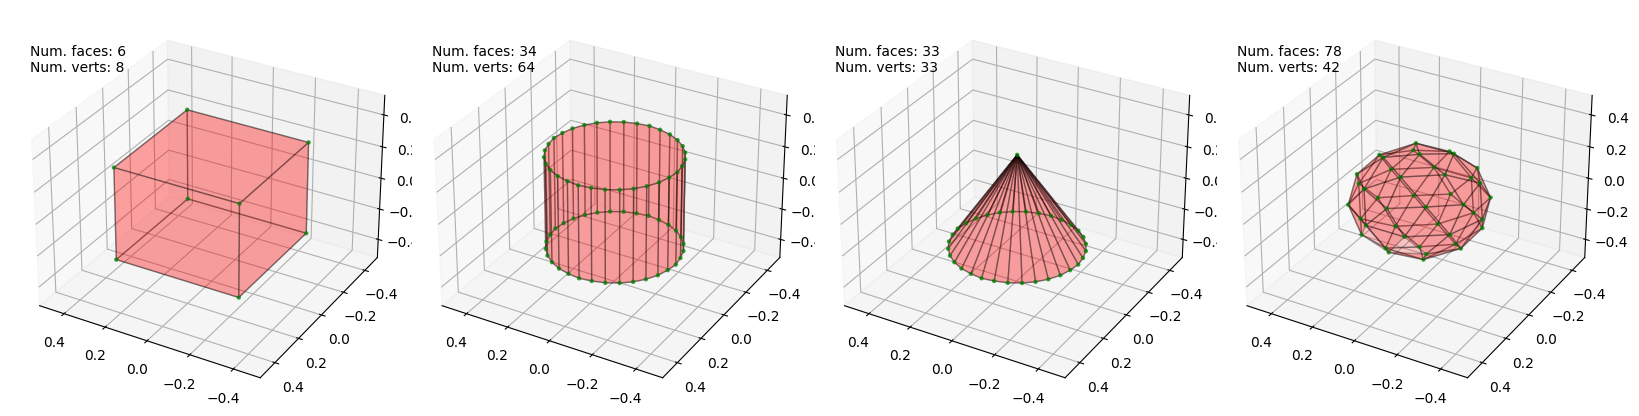

Step 165
Loss (vertices) 3.3661928176879883
Loss (faces) 12.824718475341797
Time (ms): 283.9992046356201
Step 170
Loss (vertices) 3.196826934814453
Loss (faces) 11.634210586547852
Time (ms): 262.0053291320801


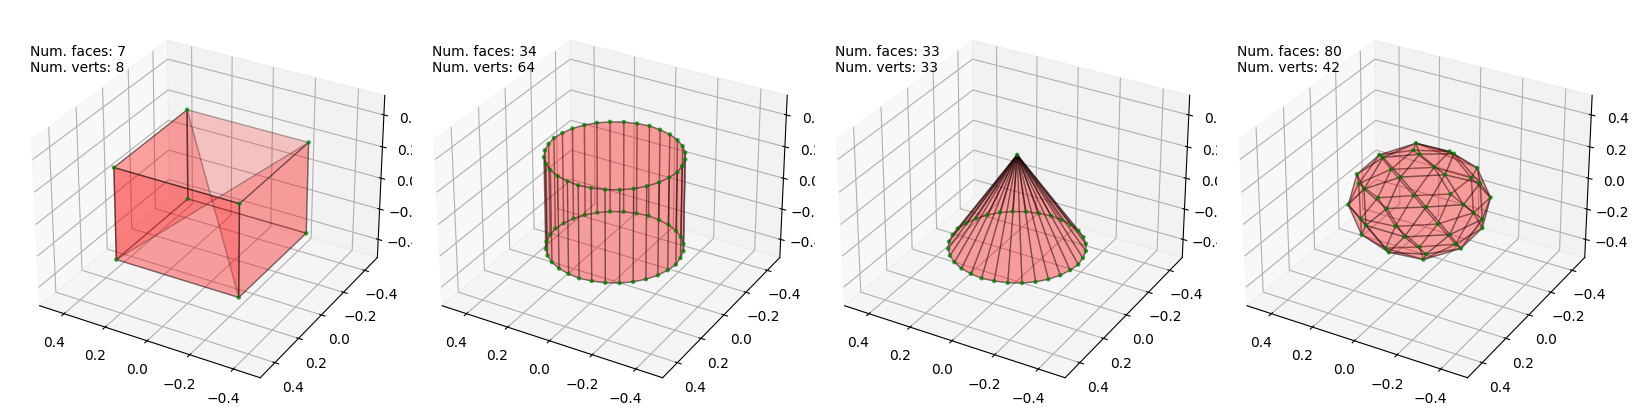

Step 175
Loss (vertices) 3.04439640045166
Loss (faces) 10.623644828796387
Time (ms): 261.0008716583252
Step 180
Loss (vertices) 2.9043664932250977
Loss (faces) 9.755619049072266
Time (ms): 255.0027370452881


KeyboardInterrupt: 

In [ ]:
# Optimization settings
#learning_rate = 1e-3
learning_rate = 5e-4
training_steps = 500
log_step = 5
n_samples = 4
# Create an optimizer an minimize the summed log probability of the mesh 
# sequences
#optimizer = tf.train.AdamOptimizer(learning_rate)
face_model_optim = torch.optim.AdamW(face_model.parameters(), lr=learning_rate)
vertex_model_optim = torch.optim.AdamW(vertex_model.parameters(), lr=learning_rate)
#vertex_model_optim_op = optimizer.minimize(vertex_model_loss)
#face_model_optim_op = optimizer.minimize(face_model_loss)
vertex_model_dataloader = DataLoader(vertex_model_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=pad_batch)
vertex_model_dataloader = iter(vertex_model_dataloader)

face_model_dataloader = DataLoader(face_model_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=pad_batch)
face_model_dataloader = iter(face_model_dataloader)

def get_batch_from_dataloader(dataloader, dataset):
  try:
    batch = next(dataloader)
  except StopIteration:
    dataloader = iter(DataLoader(dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=pad_batch))
    batch = next(dataloader)
  return batch

import time
# Training loop
for n in range(training_steps):
    #vertex_model_batch = get_batch_from_dataloader(vertex_model_dataloader, vertex_model_dataset)
    t = time.time()
    try:
      vertex_model_batch = next(vertex_model_dataloader)
    except StopIteration:
      vertex_model_dataloader = iter(DataLoader(vertex_model_dataset, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size, 
                                                collate_fn=pad_batch))
      vertex_model_batch = next(vertex_model_dataloader)
    
    vertex_model_pred_dist = vertex_model(vertex_model_batch)
    vertex_model_loss = -torch.sum(
    	vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) * 
    	vertex_model_batch['vertices_flat_mask'])  
    
    #face_model_batch = get_batch_from_dataloader(face_model_dataloader, face_model_dataset)
    try:
      face_model_batch = next(face_model_dataloader)
    except StopIteration:
      face_model_dataloader = iter(DataLoader(face_model_dataset, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size, 
                                                collate_fn=pad_batch))
      face_model_batch = next(face_model_dataloader)
    
   #print("face_model_batch", face_model_batch)
    face_model_pred_dist = face_model(face_model_batch)
    face_model_loss = -torch.sum(face_model_pred_dist.log_prob(face_model_batch['faces']) * 
		  face_model_batch['faces_mask'])
    #print("FACE", face_model_batch['faces_mask'])

    # time forward pass
    dt = time.time() - t
    if n % log_step == 0:
        print('Step {}'.format(n))
        print('Loss (vertices) {}'.format(vertex_model_loss))
        print('Loss (faces) {}'.format(face_model_loss)) 
        print('Time (ms): {}'.format(dt * 1000))
        if n % 10 == 0:   
          vertex_samples = vertex_model.sample(
          n_samples, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
          recenter_verts=False, only_return_complete=False)    
          face_samples = face_model.sample(
          context=vertex_samples, max_sample_length=500, top_p=0.95,
          only_return_complete=False)    
          mesh_list = []
          for n in range(min(n_samples, batch_size)):
              mesh_list.append(
                {
                  'vertices': vertex_samples['vertices'][n][:vertex_samples['num_vertices'][n]],
                  'faces': data_utils.unflatten_faces(
                    face_samples['faces'][n][:face_samples['num_face_indices'][n]])
                }
              )
          try:
            data_utils.plot_meshes(mesh_list, ax_lims=0.5)
          except:
            print("Error plotting meshes... skipping.")
    # Run the optimization step after sample so it uses the old parameters
    vertex_model_optim.zero_grad()
    vertex_model_loss.backward()
    vertex_model_optim.step()
    face_model_optim.zero_grad()
    face_model_loss.backward()
    face_model_optim.step()
    

Step 135
Loss (vertices) 8.973716735839844
Loss (faces) 13.389995574951172

Step 140
Loss (vertices) 8.316763877868652
Loss (faces) 11.609461784362793
SAMPLE_FACE

Step 135
Loss (vertices) 5.489474296569824
Loss (faces) 10.778252601623535

Step 140
Loss (vertices) 4.984587669372559
Loss (faces) 9.428738594055176
SAMPLE_FACE

Step 175
Loss (vertices) 2.778308868408203
Loss (faces) 7.1154890060424805
Time (ms): 200.55532455444336

Step 180
Loss (vertices) 2.6389522552490234
Loss (faces) 6.346826553344727
Time (ms): 204.00118827819824

Step 175
Loss (vertices) 3.04439640045166
Loss (faces) 10.623644828796387
Time (ms): 261.0008716583252
Step 180
Loss (vertices) 2.9043664932250977
Loss (faces) 9.755619049072266
Time (ms): 255.0027370452881